# Instituto de Educação Superior de Brası́lia – IESB
## Pós-Graduação em Inteligência Artificial
### Deep Learning e Redes Neurais

### Atividade 3 - Remoção de Ruído de Imagens com Autoencoder Convolucional - Dataset EMNIST


## 1) Carregue o Dataset

 * Os datasets fornecidos estão salvos em formato binário Big Endian, que seguem a seguinte lógica:
 <br>
 <br>
 
  __Arquivo de Imagens__:
 
    | Tamanho <br>(Bytes)    |   Elemento      | Descrição              |
    |:---------------------: | :-------------: | :--------------------: |
    | 4                      | MAGIC NUMBER    | ($2051_{10}$)          |
    | 4                      | COUNT           | Quantidade de imagens  |
    | 4                      | HEIGHT          | Altura da imagem       |
    | 4                      | WIDTH           | Largura da imagem      | 
    | HEIGHT$\times$WIDTH    | IMG_1           | 1ª imagem              |
    | HEIGHT$\times$WIDTH    | IMG_2           | 2ª imagem              |
    | $\vdots$               | $\vdots$        | $\vdots$               |
    | HEIGHT$\times$WIDTH    | IMG_COUNT       | Última imagem          |
    |========================|=================|========================|

<br>
  
 - Carregue as bases de treino e de teste (X_train, X_test).

In [ ]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras import Input
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import clear_session
from tensorflow.keras.datasets import mnist
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
import numpy as np
import gzip
    
def load_dataset(img, lbl):
  with gzip.open(img) as file:
    magic_num = int.from_bytes(bytes=file.read(4), byteorder='big', signed=False)
    count = int.from_bytes(bytes=file.read(4), byteorder='big', signed=False)
    height = int.from_bytes(bytes=file.read(4), byteorder='big', signed=False)
    width = int.from_bytes(bytes=file.read(4), byteorder='big', signed=False)
    X = np.frombuffer(buffer=file.read(count*height*width), dtype='uint8')
    X = X.reshape(count, height, width)
      
      
  with gzip.open(lbl) as file:
    magic_num = int.from_bytes(bytes=file.read(4), byteorder='big', signed=False)
    count = int.from_bytes(bytes=file.read(4), byteorder='big', signed=False)
    y = np.frombuffer(buffer=file.read(count), dtype='uint8')
    y = y.reshape(count,)

    return X, y


In [ ]:
X_train, y_train = load_dataset(img='train-images.gz',
                                lbl='train-labels.gz')


X_test, y_test = load_dataset(img='test-images.gz',
                              lbl='test-labels.gz')


print()
print(' >> X_train:')
print(f'    Shape:    {X_train.shape}')
print(f'    Range:    [{X_train.min()}, {X_train.max()}]')
print()
print(' >> X_test:')
print(f'    Shape:    {X_test.shape}')
print(f'    Range:    [{X_test.min()}, {X_test.max()}]')
print()


 >> X_train:
    Shape:    (60000, 28, 28)
    Range:    [0, 255]

 >> X_test:
    Shape:    (10000, 28, 28)
    Range:    [0, 255]



## 2) Verifique o formato dos conjuntos carregados

 - Imprima shape, tipo do dado e range (min/max) dos datasets

In [ ]:
print(X_train.shape)
print(X_test.shape)



(60000, 28, 28)
(10000, 28, 28)


## 3) Adeque, se necessário: tipo, shape e range dos dados para o formato esperado pelo Autoecoder

In [ ]:
X_train = X_train / 255
X_test  = X_test  / 255




## 4) Crie cópias dos datasets de treino e de teste, e contamine-as com ruído gaussiano

Utilizar para o ruído:

    - Média = 0
    - Desvio Padrão = 1
    - Fator multiplicativo de ruído = 0.5
    
Clipe as imagens contaminadas em valores entre 0 e 1 .

OBS: Crie versões de ruído distintas para cada base! 

In [ ]:
fator = 0.5
X_train_r = X_train + fator*np.random.normal(loc=0, scale=1, size=X_train.shape)
X_test_r = X_test + fator*np.random.normal(loc=0, scale=1, size=X_test.shape)

X_train__r = np.clip(X_train_r, a_min=0, a_max=1)
X_test_r = np.clip(X_test_r, a_min=0, a_max=1)


print()
print(' >> X_train_r:')
print(f'    Shape:    {X_train_r.shape}')
print(f'    Range:    [{X_train_r.min()}, {X_train_r.max()}]')
print()
print(' >> X_test_r:')
print(f'    Shape:    {X_test_r.shape}')
print(f'    Range:    [{X_test_r.min()}, {X_test_r.max()}]')
print()




 >> X_train_r:
    Shape:    (60000, 28, 28)
    Range:    [-2.89710887259282, 3.529040658886239]

 >> X_test_r:
    Shape:    (10000, 28, 28)
    Range:    [0.0, 1.0]



In [ ]:
print(X_train_r.shape)

(60000, 28, 28)


## 5)  Verifique o resultado da contaminação de ruído nas imagens
 - Escolha __10__ imagens, de forma aleatória, de cada base (treino e teste), e plote as versões originais e com ruído de cada uma

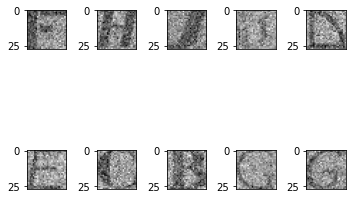

In [ ]:
N = 10

idxs = np.random.randint(low=0, high=len(X_train_r), size=N)

plt.figure(figsize=(5, 5))
for (i, idx) in enumerate(idxs):
    plt.subplot(2, 5, i+1)
    plt.imshow(np.reshape(X_train_r[idx], (28, 28)), cmap='gray_r')
    plt.xticks([])
plt.tight_layout()
plt.show()

## 6) Construa o modelo de autoencoder convolucional

In [ ]:
def create_conv_autoencoder(input_shape, code_len):
    
    # Criando Encoder
    enc_in = Input(shape=input_shape, name='enc_in')
    
    x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(enc_in)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same')(x)
    pre_flatten_shape = x.shape[1:]

    x = Flatten()(x)
    latent = Dense(units=code_len, activation='relu')(x)
    
    encoder = Model(
        inputs=enc_in,
        outputs=latent,
        name='encoder'
    )
    
    # Criando Decoder
    dec_in = Input(shape=(code_len,), name='dec_in')
    
    x = Dense(units=np.prod(pre_flatten_shape), activation='relu')(dec_in)
    x = Reshape(pre_flatten_shape)(x)

    x = Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same')(x)
  
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same')(x)

    x = UpSampling2D((2, 2))(x)
    x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
  
    dec_out = Conv2D(filters=1, kernel_size=(3, 3), activation='sigmoid', padding='same')(x)

    decoder = Model(
       inputs=dec_in,
       outputs=dec_out,
       name='decoder',
    )
    
    # Criando AutoEncoder Completo
    autoencoder = Model(
       inputs=enc_in,
       outputs=decoder(encoder(enc_in)),
       name='conv_ae',
    )
    
    return autoencoder, encoder, decoder

In [ ]:
clear_session()

autoencoder, encoder, decoder = create_conv_autoencoder(input_shape=(28,28,1), code_len=36)

## 7) Defina os parâmetros para o treinamento do modelo *autoencoder*

In [ ]:
opt = Adam(learning_rate=1e-3)

autoencoder.compile(
    loss='mean_squared_error',
    optimizer=opt,
)

## 8) Treine o modelo

In [ ]:
MAX_EPOCHS = 10
BATCH_SIZE = 256


es = EarlyStopping(
    monitor='val_loss',
    patience=int(0.1*MAX_EPOCHS),
    min_delta=1e-4,
    restore_best_weights=True,
    verbose=True,
)

red_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=10,
    factor=0.75,
    min_lr=1e-5,
    verbose=True,
)


hist = autoencoder.fit(
    x=X_train_r, y=X_train,
    batch_size=BATCH_SIZE,
    epochs=MAX_EPOCHS,
    validation_data=(X_test_r, X_test),
    callbacks=[es, red_lr],
    workers=os.cpu_count(),
)

Epoch 1/10
235/235 [==============================] - 34s 11ms/step - loss: 0.1062 - val_loss: 0.1096
Epoch 2/10
235/235 [==============================] - 2s 9ms/step - loss: 0.0541 - val_loss: 0.0777
Epoch 3/10
235/235 [==============================] - 2s 9ms/step - loss: 0.0476 - val_loss: 0.0682
Epoch 4/10
235/235 [==============================] - 2s 9ms/step - loss: 0.0440 - val_loss: 0.0584
Epoch 5/10
235/235 [==============================] - 2s 9ms/step - loss: 0.0420 - val_loss: 0.0543
Epoch 6/10
235/235 [==============================] - 2s 9ms/step - loss: 0.0405 - val_loss: 0.0453
Epoch 7/10
235/235 [==============================] - 2s 9ms/step - loss: 0.0393 - val_loss: 0.0410
Epoch 8/10
235/235 [==============================] - 2s 9ms/step - loss: 0.0384 - val_loss: 0.0395
Epoch 9/10
235/235 [==============================] - 2s 9ms/step - loss: 0.0377 - val_loss: 0.0382
Epoch 10/10
235/235 [==============================] - 2s 9ms/step - loss: 0.0370 - val_loss: 0.03

## 9) Plote as curvas da função custo do conjunto de treino e de validação

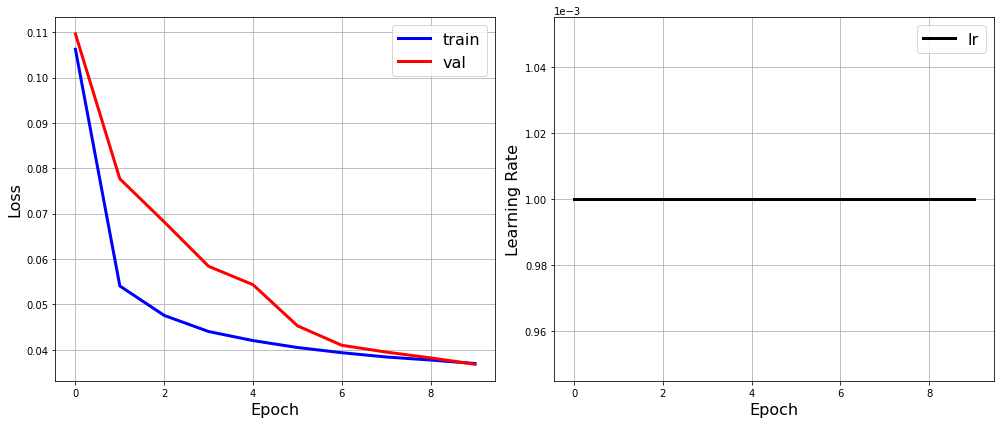

In [ ]:
plt.figure(figsize=(14, 6))

plt.subplot(121)
plt.plot(hist.history['loss'], label='train', c='b', linewidth=3)
plt.plot(hist.history['val_loss'], label='val', c='r', linewidth=3)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=16)
plt.grid(True)

plt.subplot(122)
plt.plot(hist.history['lr'], label='lr', c='k', linewidth=3)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Learning Rate', fontsize=16)
plt.legend(fontsize=16)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
plt.grid(True)

plt.tight_layout()
plt.show()


## 10) Escolha __10__ exemplos aleatórios de imagens da base de teste (com ruído), e reconstrua-as com o *autoecoder* treinado. Mostre graficamente, para essas 10 imagens:

 * Imagem original (sem ruído)
 * Imagem de entrada (com ruído)
 * Vetor Latente
 * Imagem Reconstruída


In [ ]:

coded_imgs = encoder.predict(X_test_r)


decod_imgs = decoder.predict(coded_imgs)

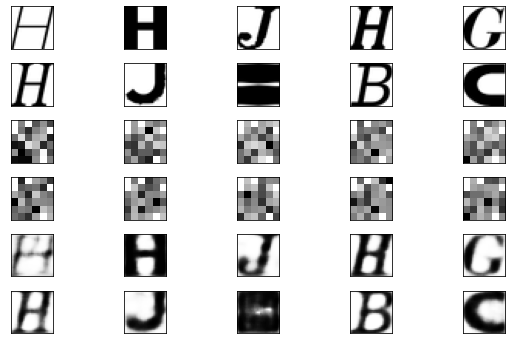

In [ ]:
# Vericando a codificação e decodificação em 5 imagens aleatórias
num_imgs = 10
idxs = np.random.randint(low=0, high=len(X_test), size=num_imgs)

plt.figure(figsize=(8, 8))

for i, idx in enumerate(idxs):
  # Originais
  plt.subplot(10, 5, i+1)
  plt.imshow(np.reshape(X_test[idx], (28, 28)), cmap='gray_r')
  plt.xticks([])
  plt.yticks([])

  # Codificadas
  plt.subplot(10, 5, i+1 + 1*num_imgs)
  plt.imshow(np.reshape(coded_imgs[idx], (6, 6)), cmap='gray_r')
  plt.xticks([])
  plt.yticks([])

  # Reconstruidas
  plt.subplot(10, 5, i+1 + 2*num_imgs)
  plt.imshow(np.reshape(decod_imgs[idx], (28, 28)), cmap='gray_r')
  plt.xticks([])
  plt.yticks([])

plt.tight_layout()
plt.show()

## 11) Avaliação quantitiva utilizando SNR

- A SNR é uma métrica comumente utilizada para avaliar reconstrução de imagens. 
- Quando maior esse valor, melhor a qualidade da reconstruição.
- É definida, em decibéis (dB), como:

$
\text{SNR}_{\text{dB}} = 20 \cdot \log{\left( \frac{\sum\text{I}_\text{orig}}{\sum\left| \text{I}_\text{orig} - \text{I}_\text{reconst} \right| } \right)}
$

 - Calcule a SNR para cada imagem reconstruida na base de teste, e guarde esses valores em um vetor.

 - Em seguida, apresente em um historgrama a distribuição das SNRs calculadas.

In [ ]:
def snr_db(im_original, im_reconstructed):
    """
    Calcula a SNR, em dB, de uma reconstrução.
    
    Parâmetros:
        im_original : Numpy.Array
            Matriz da imagem original, com shape (H, W, C)

        im_reconstructed : Numpy.Array
            Matriz da imagem reconstruída, com shape (H, W, C)
            
    Retorno:
        snr : float
            SNR calculada em dB.
    """
    import numpy as np
    orig_sum = np.sum(im_original)
    error_sum = np.abs(np.sum(im_original - im_reconstructed))
    snr = 20 * np.log10(orig_sum/error_sum)
    return snr

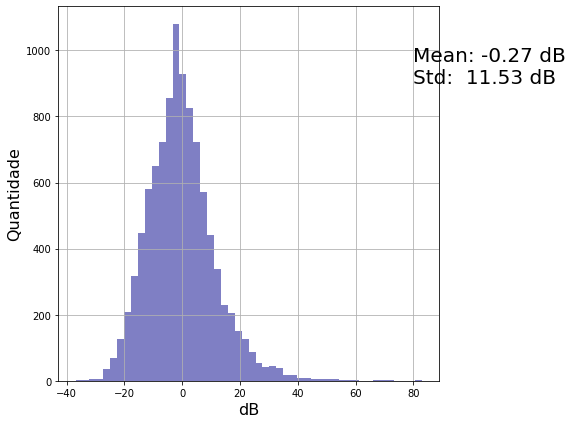

In [ ]:
snr_decoded = [snr_db(original, reconstructed) for original, reconstructed in zip(X_test, decod_imgs)]

snr_mean = np.mean(snr_decoded)
snr_std  = np.std(snr_decoded)

plt.figure(figsize=(8, 6))

plt.hist(snr_decoded, bins=50, color='darkblue', alpha=0.5)
plt.text(x=80, y=900, s=f'Mean: {snr_mean:.2f} dB\nStd:  {snr_std:.2f} dB', fontsize=20)
plt.ylabel('Quantidade', fontsize=16)
plt.xlabel('dB', fontsize=16)

plt.grid(True)

plt.tight_layout()
plt.show()
